In [1]:
import pIMPACT as pip
import numpy as np
np.set_printoptions(precision=3)
from IPython.display import Image

## Build FODO lattice

In [2]:
print pip.getElem.__doc__


    f = getElem(elemType)
    get a template of an element dictionary.  
    input 
        elemType = (str) element type. one of the following
                   'drift', 'quad', 'bend', 'scrf', 
                   'kick', 'write full', 'restart', 'halt'
    output 
        f = (dict) element dictionary
    


In [3]:
D0 = pip.getElem('drift')
D1 = pip.getElem('drift')
Qf = pip.getElem('quad')
Qd = pip.getElem('quad')
print D0
print Qf

{'n_map': 1, 'radius': 1.0, 'length': 0.1, 'type': 'drift', 'n_sckick': 1}
{'n_map': 1, 'length': 0.1, 'radius': 1.0, 'B1': 17.0, 'dx': 0.0, 'dy': 0.0, 'input file id': 0, 'type': 'quad', 'n_sckick': 2}


In [4]:
D0['length'] = 0.5  # drift length [meter]
D1['length'] = 1.0
Qf['length'] = 0.2   # quad [meter]
Qd['length'] = 0.2
Qf['B1']     =-8.0   # quad strength [Tesla]
Qd['B1']     = 8.0
Qf['n_sckick'] = 10   # number of IMPACTz integration steps
Qd['n_sckick'] = 10

lattice = [D0,Qf,D1,Qd,D0]  # FOCO cell

In [5]:
# print, check lattice
for i in range(len(lattice)):
    print str(i)+'th element of lattice is',lattice[i]['type'], 'of length',lattice[i]['length']

0th element of lattice is drift of length 0.5
1th element of lattice is quad of length 0.2
2th element of lattice is drift of length 1.0
3th element of lattice is quad of length 0.2
4th element of lattice is drift of length 0.5


## Get linear transfer map of FODO lattice

In [6]:
print pip.getTransferMap.__doc__


    M = getTransferMap(lattice,q,mass,ke,freq,
                       epsilon=[1e-9,1e-6,1e-9,1e-6,1e-3,1e-9],
                       fname='test.in' )
    get linear transfer map (without space-charge)  by tracking 6 particles
    whose initial phase-space perturbation given by epsilon
    input                
        lattice = (dict) lattice dictionary whose transvermap to be determined
        q = charge (-1.0 for electron)
        ke = reference particle energy at lattice entrance [MeV]
        mass = particle mass [MeV]
        freq = reference RF frequency [Hz]
        epsilon = 6 dimension array of perturbation for 
                  x,px,y,py, z*360/v/freq, E  in unit of 
                  [m],[rad],[m],[rad],[deg],[MeV]
                  default : epsilon = [1e-e-8,1e-6,1e-8,1e-6,1e-7,1e-8]
        fname = input file name for IMPACTz 
                depending on version of IMPACTz the file name may change
                default is 'test.in'
    


In [7]:
ke = 1e3 # kinetic energy [MeV]
mass = 0.510999 # electron mass [MeV]
freq = 300e6    # reference rf freq [Hz]
q = 1.0  # electron charge
M = pip.getTransferMap(lattice,q,mass,ke,freq)
print M

[[  1.428e+00   2.316e+00   0.000e+00   0.000e+00   0.000e+00   0.000e+00]
 [ -2.606e-01   2.776e-01   0.000e+00   0.000e+00   0.000e+00   0.000e+00]
 [  0.000e+00   0.000e+00   2.776e-01   2.316e+00   0.000e+00   0.000e+00]
 [  0.000e+00   0.000e+00  -2.606e-01   1.428e+00   0.000e+00   0.000e+00]
 [ -1.221e-05   4.701e-04  -1.221e-05   4.356e-04   1.000e+00   0.000e+00]
 [  0.000e+00   0.000e+00   0.000e+00   0.000e+00   0.000e+00   1.000e+00]]


# Optimization of optics

#### The optics parameter from transfer map

In [8]:
cosPhi = (M[0,0]+M[1,1])/2.0
betX = np.sqrt(M[0,1]*M[0,1]/(1-cosPhi*cosPhi))
sinPhi = M[0,1]/betX
phiX = np.mod( np.arctan(sinPhi/cosPhi)*180/np.pi , 360)
alfX = (M[0,0]-M[1,1])/2.0/sinPhi
print betX,alfX,phiX

4.43418063338 1.10107182352 31.4903725272


#### Define cost function whose goal is phiX = 70 deg

In [9]:
def costFunc(B):
    Qf['B1'] = -B[0]
    Qd['B1'] = B[0]
    M = pip.getTransferMap(lattice,-1.0,mass,ke,freq)
    cosPhi = (M[0,0]+M[1,1])/2
    if cosPhi>=1.0:
        return np.nan
    sinPhi = M[0,1]/betX
    phiX = np.mod( np.arctan(sinPhi/cosPhi)*180/np.pi , 360)
    return (phiX-70.0)**2

#### Run optimization algorithm (differential evoluation)

In [10]:
print pip.opt.differential_evolution.__doc__


    result = differential_evolution(func, bounds, strategy='rand1bin', 
                           prev_result=OptimizeResult(), best_arg=None,
                           maxiter=None, popsize=15, tol=0.01,
                           mutation=(0.5, 1), recombination=0.9, seed=None,
                           callback=None, disp=False, polish=True, ncore=1,
                           init='random',maxtime=60*30)
    Finds the global minimum of a multivariate function.
    Differential Evolution is stochastic in nature (does not use gradient
    methods) to find the minimium, and can search large areas of candidate
    space, but often requires larger numbers of function evaluations than
    conventional gradient based techniques.
    The algorithm is due to Storn and Price [1]_.
    Parameters
    ----------
    func : callable
        The objective function to be minimized.  Must be in the form
        ``f(x)``, where ``x`` is the argument in the form of a 1-D array
    bounds : seque

In [11]:
bounds = ((8.0,20.0),)  # the comma is important for single knob optimization
result = pip.opt.differential_evolution(costFunc,bounds,popsize=10,tol=0.02,ncore=1)  
# ncore = 1 by default. 
# One need to use ipyparallel to run differential_evolution in parallel with jupyter notebook

In [12]:
print result
print result.x[0]

     fun: 1.6245831295150669e-11
 message: 'Optimization terminated successfully.'
     nit: 44
 success: True
       x: array([ 19.137])
19.1366805891


#### Check result

In [13]:
Qf['B1']=-result.x[0]
Qd['B1']= result.x[0]
M = pip.getTransferMap(lattice,q,mass,ke,freq)
cosPhi = (M[0,0]+M[1,1])/2.0
betX = np.sqrt(M[0,1]*M[0,1]/(1-cosPhi*cosPhi))
sinPhi = M[0,1]/betX
phiX = np.mod( np.arctan(sinPhi/cosPhi)*180/np.pi , 360)
alfX = (M[0,0]-M[1,1])/2.0/sinPhi
print 'betX,alfX,phiX =',betX,alfX,phiX
cosPhi = (M[2,2]+M[3,3])/2.0
betY = np.sqrt(M[2,3]*M[2,3]/(1-cosPhi*cosPhi))
sinPhi = M[2,3]/betY
phiY = np.mod( np.arctan(sinPhi/cosPhi)*180/np.pi , 360)
alfY = (M[2,2]-M[3,3])/2.0/sinPhi
print 'betY,alfY,phiY =',betY,alfY,phiY

betX,alfX,phiX = 1.94511222744 1.39143964612 80.9286982792
betY,alfY,phiY = 1.94511222195 -1.39143933772 80.9286992922


In [14]:
beam = pip.getBeam()
beam['mass'] = mass*1e6
beam['charge per mass'] = q/beam['mass']
beam['energy'] = ke*1e6
beam['n_particles'] = 4096
beam['frequency'] = freq
beam['distribution id'] = 3  # water bag distribution
beam['current'] = 0.0
print beam

{'energy': 1000000000.0, 'frequency': 300000000.0, 'mesh_x': 16, 'y00': 0.0, 'y01': 0.0, 'distribution id': 3, 'z01': 0.0, 'z00': 0.0, 'current': 0.0, 'mesh_y': 16, 'mesh_z': 16, 'standard output': 1, 'x01': 0.0, 'x00': 0.0, 'nCore_y': 1, 'nCore_x': 1, 'restart flag': 0, 'phase': 0.0, 'z11': 0.0, 'mass': 510999.0, 'error study flag': 0, 'n_particles': 4096, 'charge per mass': 1.9569509920763056e-06, 'x11': 0.0, 'y11': 0.0}


In [15]:
emitX = 1e-7
# somehow alpha sign was opposite for negative charge(like electron) in IMPACT. why ??!!???
pip.twiss2beam(beam,betX,q/abs(q)*alfX,emitX,
                    betY,q/abs(q)*alfY,emitX,
                    30,  0.0, emitX)
lattice.append(pip.getElem('write full'))
pip.writeIMPACT('test.in',beam,lattice)
pip.run()
print betX,alfX,emitX
print pip.readOpticsAt(0,'x')
print pip.readOpticsAt(-1,'x')

1.94511222744 1.39143964612 1e-07
(1.9321691390014666, 1.40146, 9.98882e-08)
(1.94652316515201, 1.37199, 9.98882e-08)


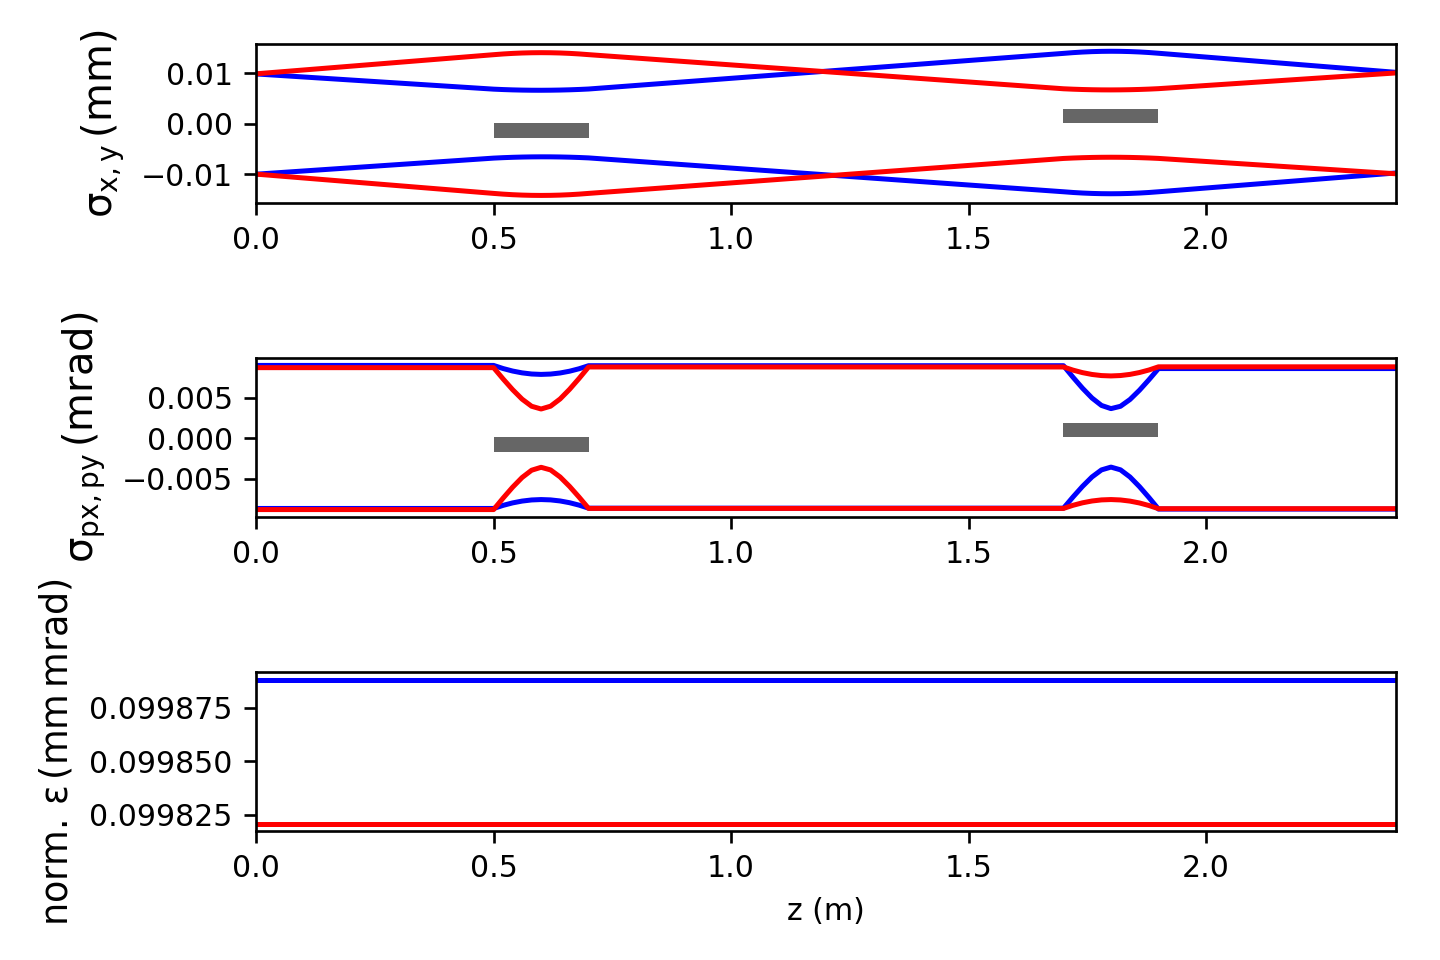

In [16]:
pip.plot.rms(savefileID=55)
Image(filename='x55.png') 